# Составление наилучшего прогноза числа автомобильных аварий в разрезе дней и недель

$_{\text{Коротков Алексей, 2021г}}$

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
dates = pd.to_datetime(pd.read_csv("accident_UK_old.csv")["Date"], dayfirst=True)
acc = pd.read_csv("accident_UK_old.csv")["Total_Accident"]

In [3]:
data = pd.DataFrame(acc.copy())
data.columns = ["y"]

In [4]:
vals = list(range(5, 32))+list(range(360,371))

In [5]:
# Adding the lag of the target variable from 100 steps back up to 400
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe 
data.tail(7)

y  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
1454  137  338.0  389.0  448.0  247.0  368.0   476.0   468.0   391.0   393.0   
1455  259  356.0  338.0  389.0  448.0  247.0   368.0   476.0   468.0   391.0   
1456  264  393.0  356.0  338.0  389.0  448.0   247.0   368.0   476.0   468.0   
1457  296  289.0  393.0  356.0  338.0  389.0   448.0   247.0   368.0   476.0   
1458  240  220.0  289.0  393.0  356.0  338.0   389.0   448.0   247.0   368.0   
1459  210  137.0  220.0  289.0  393.0  356.0   338.0   389.0   448.0   247.0   
1460  188  259.0  137.0  220.0  289.0  393.0   356.0   338.0   389.0   448.0   

      ...  lag_361  lag_362  lag_363  lag_364  lag_365  lag_366  lag_367  \
1454  ...    295.0    286.0    261.0    187.0    138.0    274.0    356.0   
1455  ...    249.0    295.0    286.0    261.0    187.0    138.0    274.0   
1456  ...    201.0    249.0    295.0    286.0    261.0    187.0    138.0   
1457  ...    242.0    201.0    249.0    295.0    286.0    261.0    187.0   
1458  ...    291.0    242.0    201.0    249.0    295.0    286.0    261.0   
1459  ...    301.0    291.0    242.0    201.0    249.0    295.0    286.0   
1460  ...    334.0    301.0    291.0    242.0    201.0    249.0    295.0   

      lag_368  lag_369  lag_370  
1454    419.0    411.0    383.0  
1455    356.0    419.0    411.0  
1456    274.0    356.0    419.0  
1457    138.0    274.0    356.0  
1458    187.0    138.0    274.0  
1459    261.0    187.0    138.0  
1460    286.0    261.0    187.0  

[7 rows x 39 columns]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [7]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [8]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [9]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [10]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,normas = True):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    if normas:
        coefs = coefs.loc[coefs.ne(0).all(axis=1)]
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

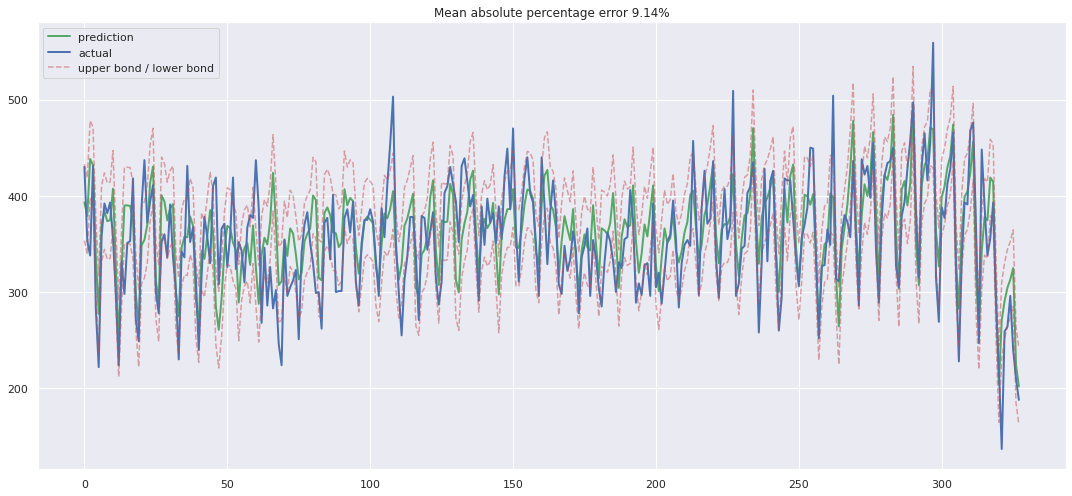

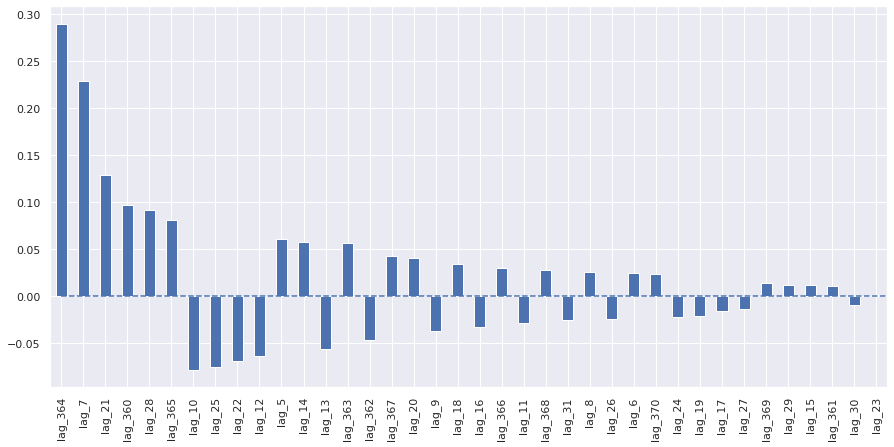

In [11]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [12]:
weekday = [(i+2)%7 for i in range(1461)]
is_weekend = [1 if (i == 5 or i==6) else 0 for i in weekday]
month = [i.month - 1 for i in dates]
print(month[0],month[31],month[31+28],month[31+28+31],month[31+28+31+30],
      month[31+28+31+30+31],month[181],month[181+31],month[181+62],month[181+92],
      month[181+92+31],month[181+92+61])

0 1 2 3 4 5 6 7 8 9 10 11


In [13]:
from math import pi, cos
for i in range(1461):
    weekday[i] = round(cos(2*pi*weekday[i]/7 + pi/6),3)
    month[i] = round(cos(2*pi*month[i]/12 + pi/7),3)

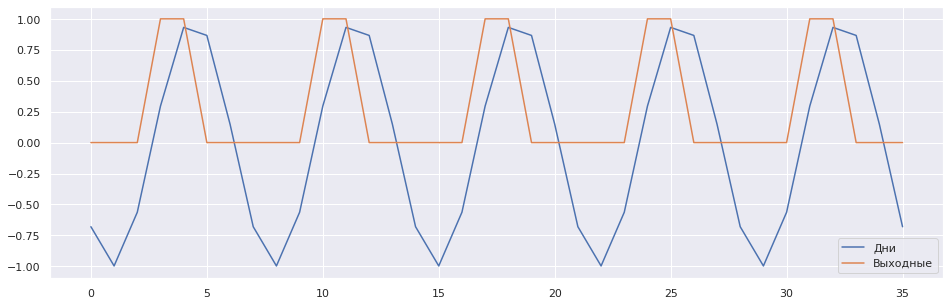

In [14]:
plt.figure(figsize=(16, 5))
plt.plot(weekday[:36],label='Дни')
plt.plot(is_weekend[:36],label = 'Выходные')
plt.legend()
plt.grid(True)

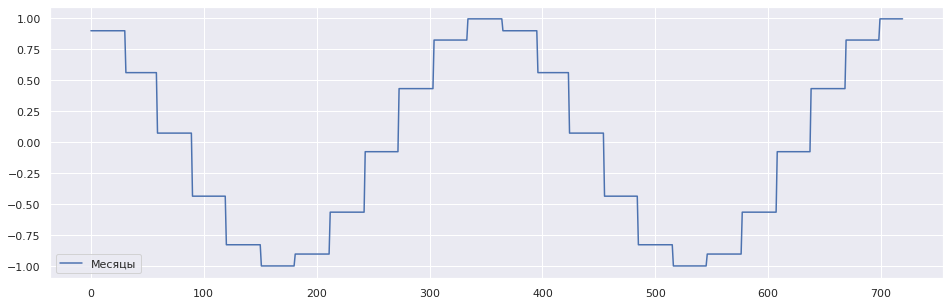

In [15]:
plt.figure(figsize=(16, 5))
plt.plot(month[:720],label = 'Месяцы')
plt.legend()
plt.grid(True)

In [16]:
data["month"] = month
data["weekday"] = weekday
data['is_weekend'] = is_weekend
data.tail(9)

y  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  lag_13  \
1452  289  448.0  247.0  368.0  476.0  468.0   391.0   393.0   334.0   228.0   
1453  220  389.0  448.0  247.0  368.0  476.0   468.0   391.0   393.0   334.0   
1454  137  338.0  389.0  448.0  247.0  368.0   476.0   468.0   391.0   393.0   
1455  259  356.0  338.0  389.0  448.0  247.0   368.0   476.0   468.0   391.0   
1456  264  393.0  356.0  338.0  389.0  448.0   247.0   368.0   476.0   468.0   
1457  296  289.0  393.0  356.0  338.0  389.0   448.0   247.0   368.0   476.0   
1458  240  220.0  289.0  393.0  356.0  338.0   389.0   448.0   247.0   368.0   
1459  210  137.0  220.0  289.0  393.0  356.0   338.0   389.0   448.0   247.0   
1460  188  259.0  137.0  220.0  289.0  393.0   356.0   338.0   389.0   448.0   

      ...  lag_364  lag_365  lag_366  lag_367  lag_368  lag_369  lag_370  \
1452  ...    274.0    356.0    419.0    411.0    383.0    372.0    265.0   
1453  ...    138.0    274.0    356.0    419.0    411.0    383.0    372.0   
1454  ...    187.0    138.0    274.0    356.0    419.0    411.0    383.0   
1455  ...    261.0    187.0    138.0    274.0    356.0    419.0    411.0   
1456  ...    286.0    261.0    187.0    138.0    274.0    356.0    419.0   
1457  ...    295.0    286.0    261.0    187.0    138.0    274.0    356.0   
1458  ...    249.0    295.0    286.0    261.0    187.0    138.0    274.0   
1459  ...    201.0    249.0    295.0    286.0    261.0    187.0    138.0   
1460  ...    242.0    201.0    249.0    295.0    286.0    261.0    187.0   

      month  weekday  is_weekend  
1452  0.997    0.295           1  
1453  0.997    0.931           1  
1454  0.997    0.866           0  
1455  0.997    0.149           0  
1456  0.997   -0.680           0  
1457  0.997   -0.997           0  
1458  0.997   -0.563           0  
1459  0.997    0.295           1  
1460  0.997    0.931           1  

[9 rows x 42 columns]

In [17]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)


# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

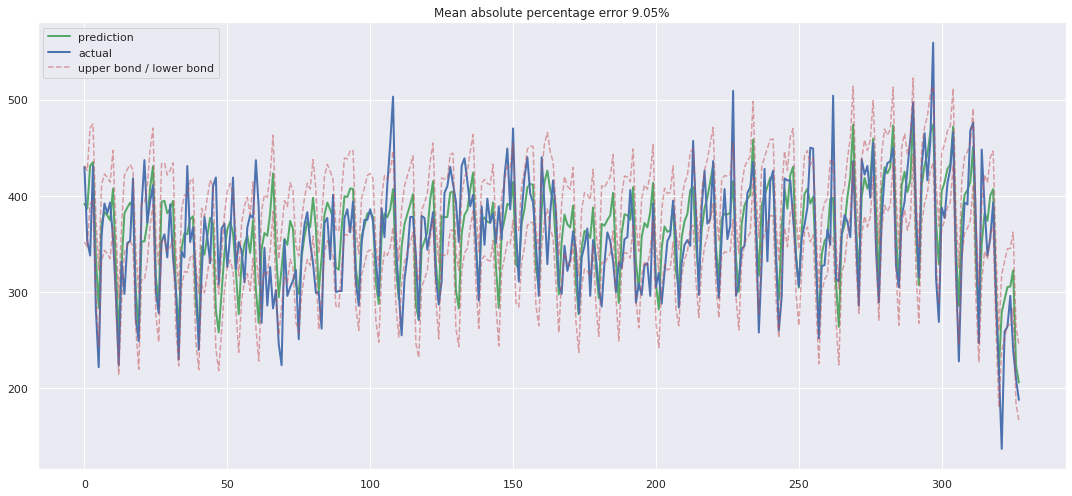

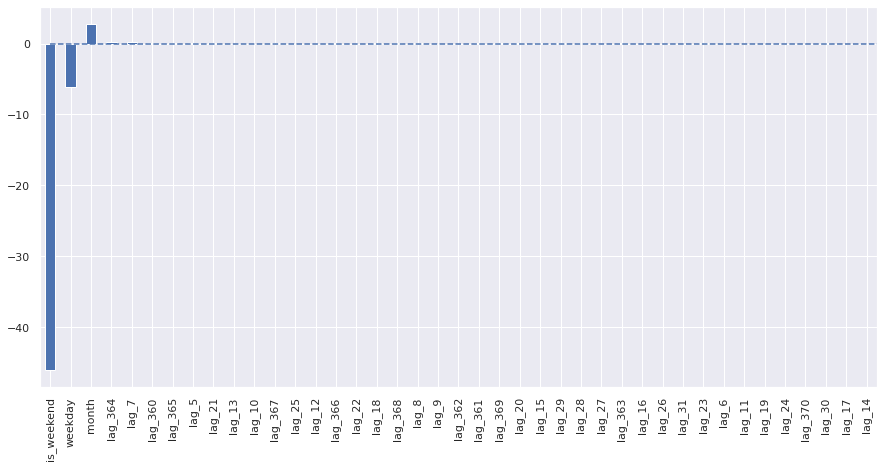

In [18]:
plotModelResults(lr, plot_intervals=True,X_test = X_test)
plotCoefficients(lr)

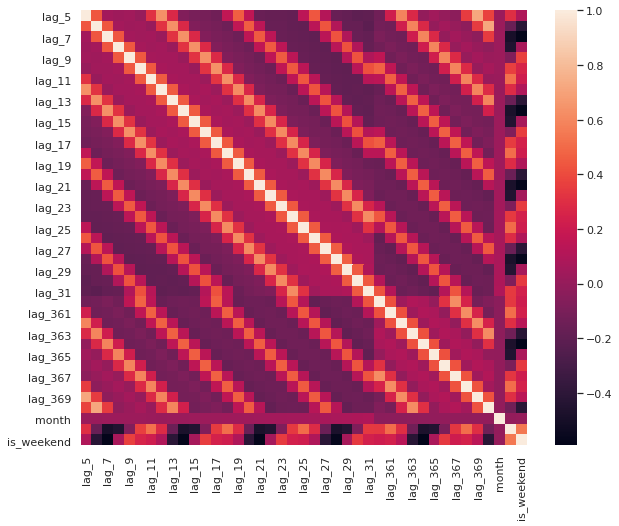

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

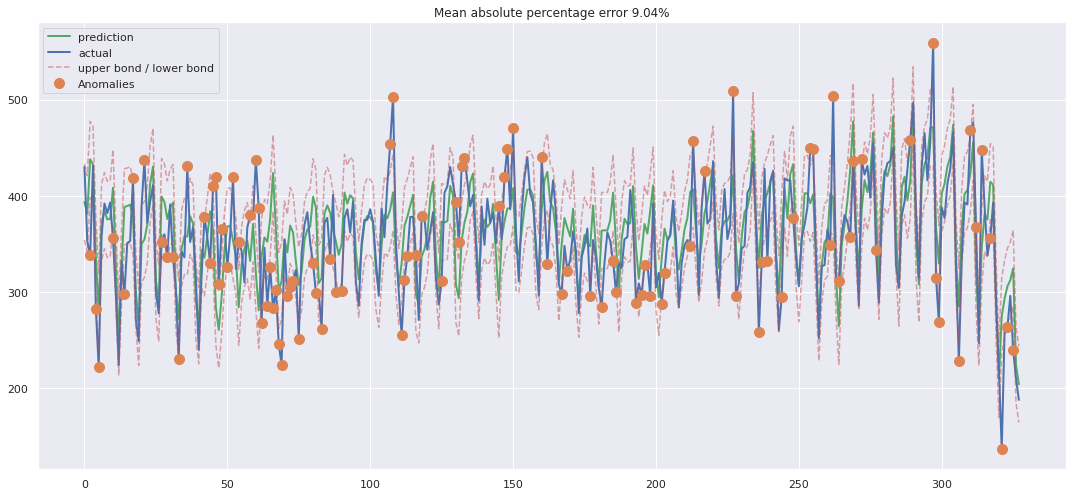

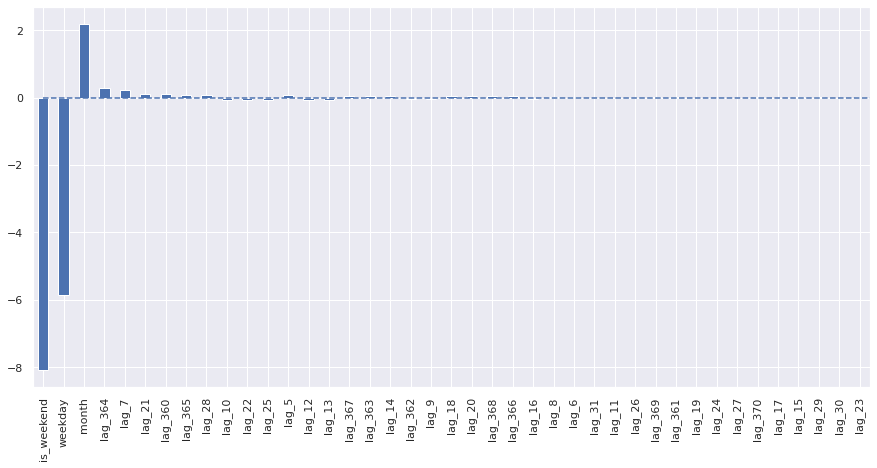

In [21]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(0, 100))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

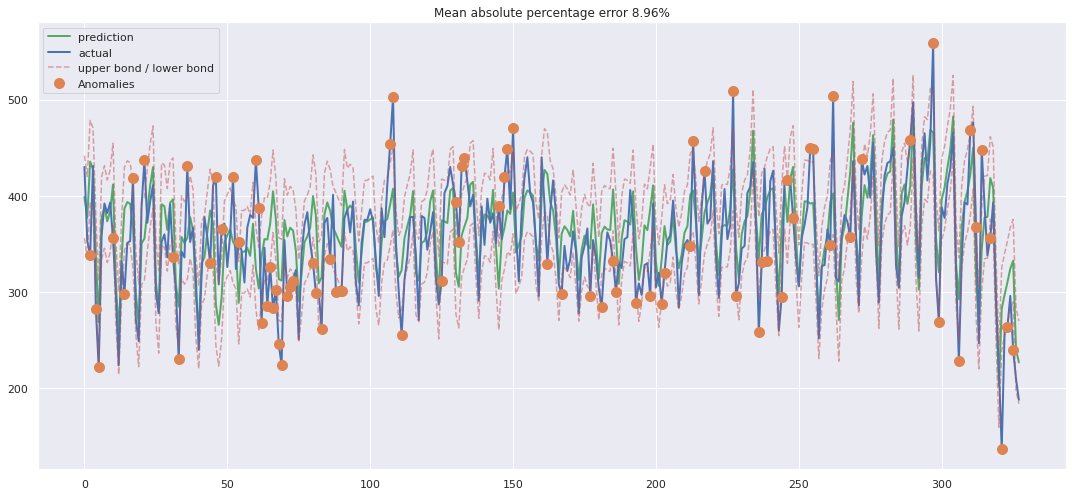

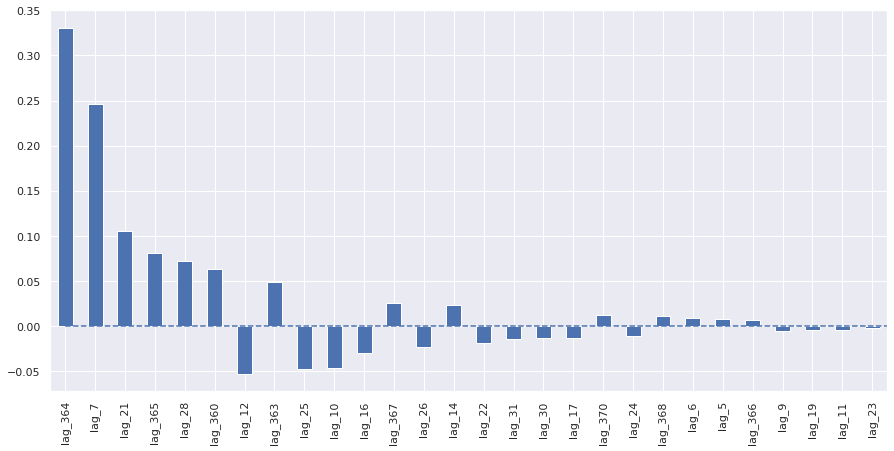

In [22]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

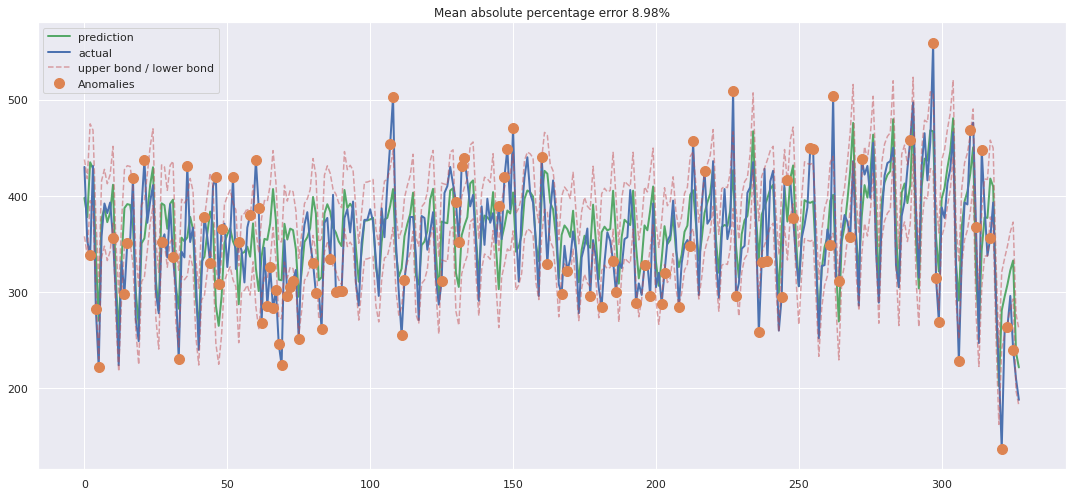

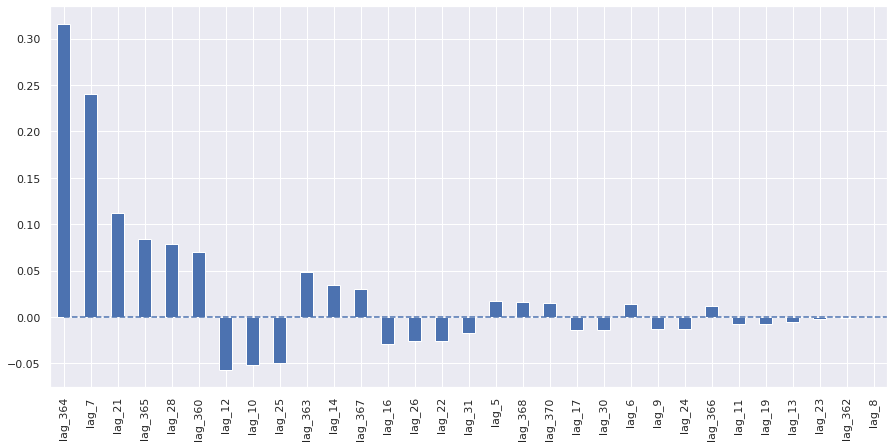

In [26]:
elaticnet = ElasticNetCV(cv=tscv, eps=0.01, alphas=np.linspace(0, 100))
elaticnet.fit(X_train, y_train)

plotModelResults(elaticnet, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(elaticnet)

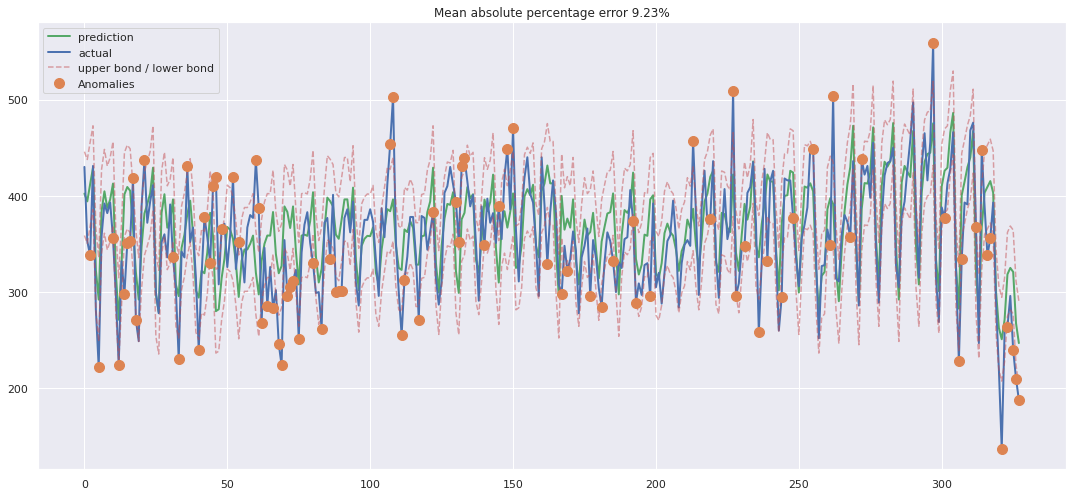

In [32]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

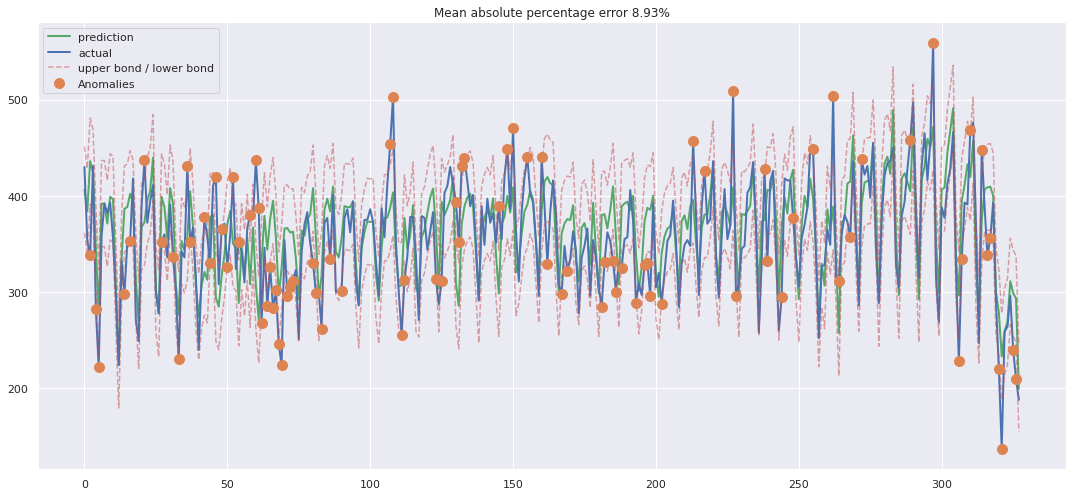

In [35]:
gbr2 = GradientBoostingRegressor(n_estimators=100)
gbr2.fit(X_train_scaled, y_train)

plotModelResults(gbr2, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

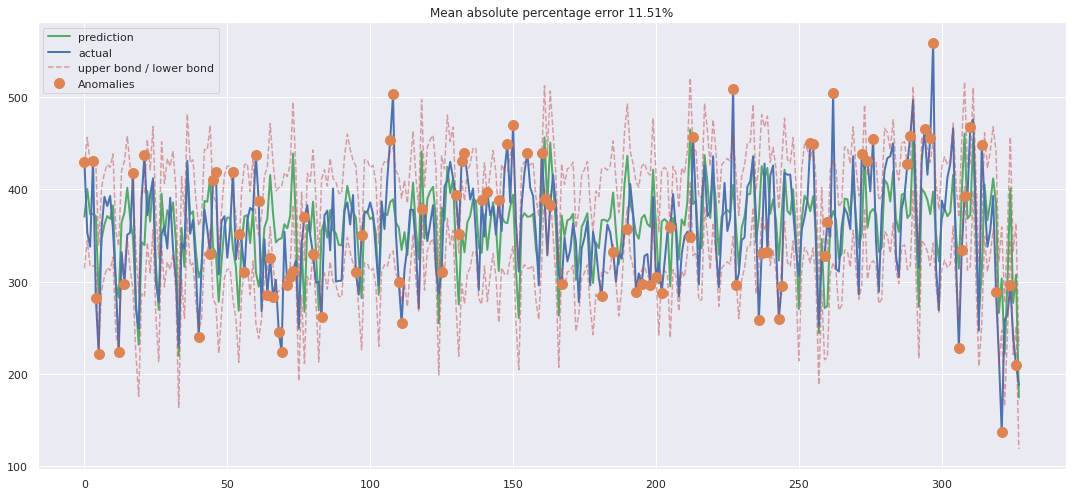

In [38]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='MAPE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Теперь будем работать с данными по неделям

In [41]:
data = pd.DataFrame({'amount': [sum(acc.values[7*i:7*(i+1)]) for i in range(len(acc.values)//7)]})

Добавим в качестве признаков некоторые лаги. Особо интересны лаги в районе 52 и первые несколько (например, десять)

In [42]:
data = pd.DataFrame(data.amount.copy())
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe 
data.tail(7)

y   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7   lag_8  \
201  2714  2669.0  2583.0  2531.0  2577.0  2486.0  2635.0  2531.0  2577.0   
202  2726  2714.0  2669.0  2583.0  2531.0  2577.0  2486.0  2635.0  2531.0   
203  2977  2726.0  2714.0  2669.0  2583.0  2531.0  2577.0  2486.0  2635.0   
204  2780  2977.0  2726.0  2714.0  2669.0  2583.0  2531.0  2577.0  2486.0   
205  2585  2780.0  2977.0  2726.0  2714.0  2669.0  2583.0  2531.0  2577.0   
206  2787  2585.0  2780.0  2977.0  2726.0  2714.0  2669.0  2583.0  2531.0   
207  1992  2787.0  2585.0  2780.0  2977.0  2726.0  2714.0  2669.0  2583.0   

      lag_9  lag_10  lag_49  lag_50  lag_51  lag_52  lag_53  
201  2652.0  2425.0  2953.0  2960.0  3029.0  2941.0  2977.0  
202  2577.0  2652.0  2938.0  2953.0  2960.0  3029.0  2941.0  
203  2531.0  2577.0  2647.0  2938.0  2953.0  2960.0  3029.0  
204  2635.0  2531.0  2046.0  2647.0  2938.0  2953.0  2960.0  
205  2486.0  2635.0  1865.0  2046.0  2647.0  2938.0  2953.0  
206  2577.0  2486.0  2453.0  1865.0  2046.0  2647.0  2938.0  
207  2531.0  2577.0  2492.0  2453.0  1865.0  2046.0  2647.0

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [44]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [45]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [46]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [47]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,normas = True):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    if normas:
        coefs = coefs.loc[coefs.ne(0).all(axis=1)]
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

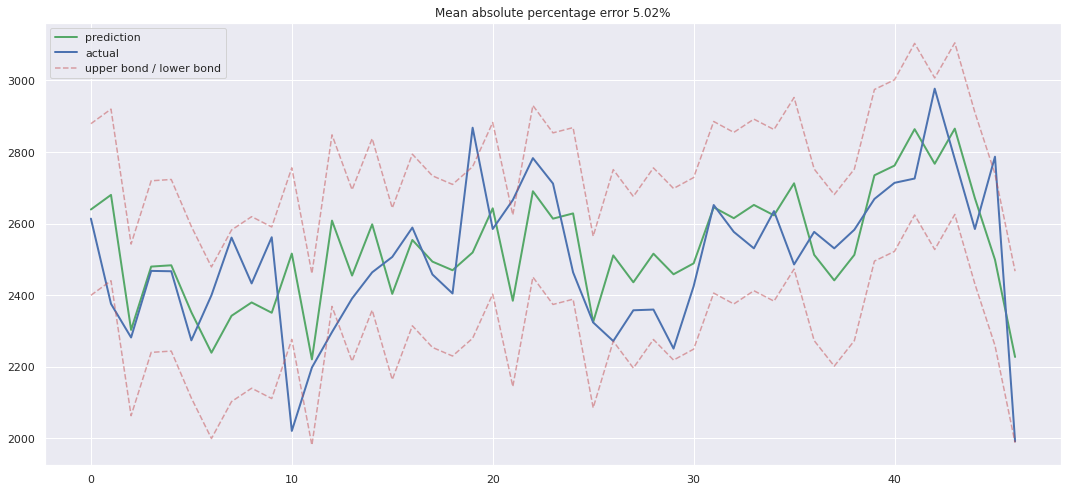

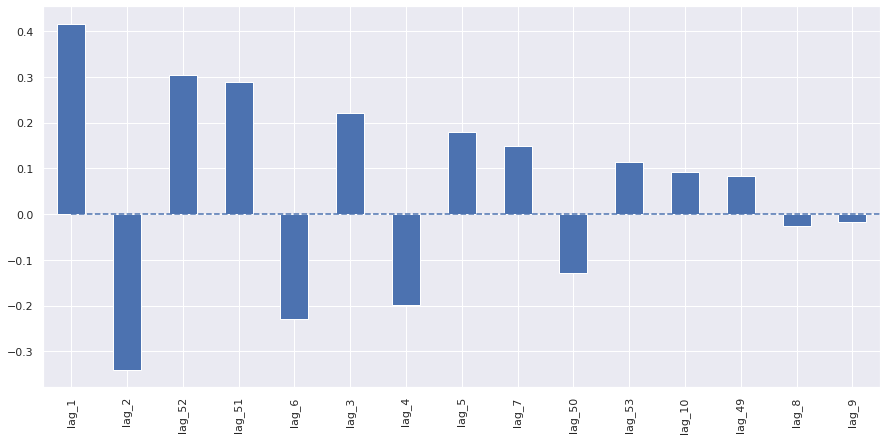

In [48]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

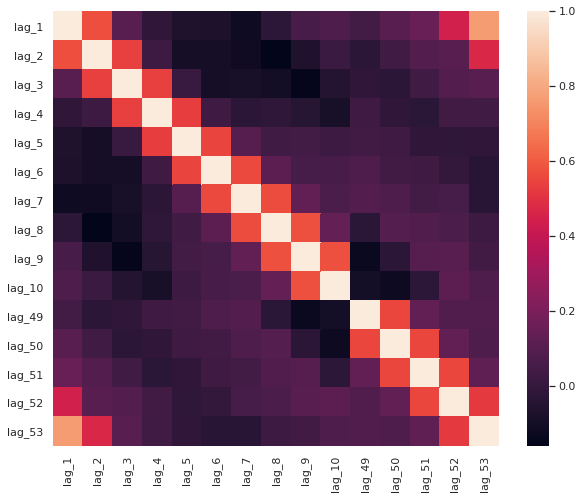

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

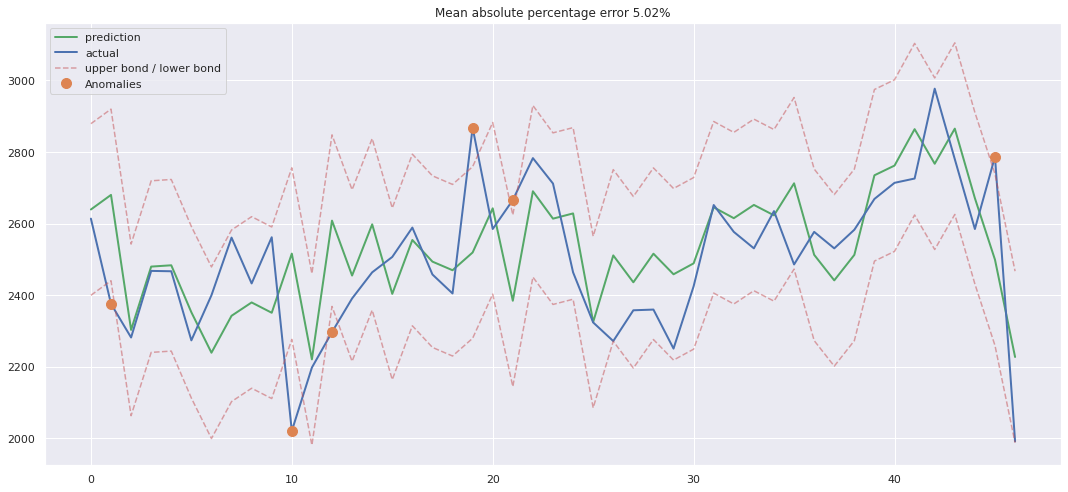

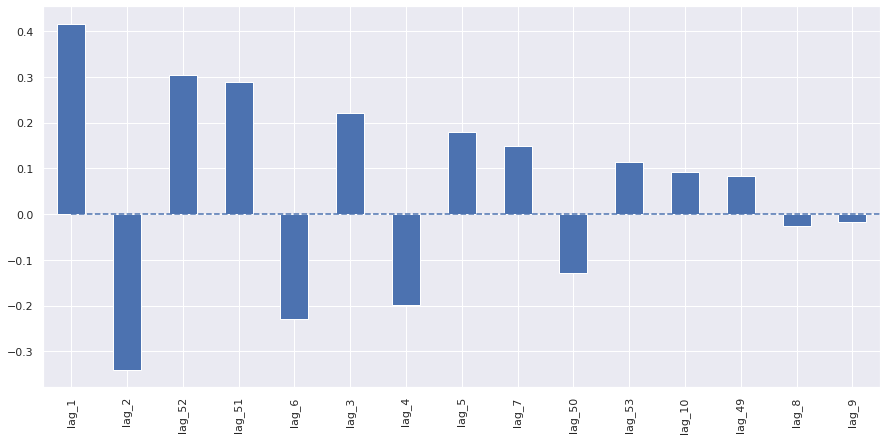

In [50]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(0, 100))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

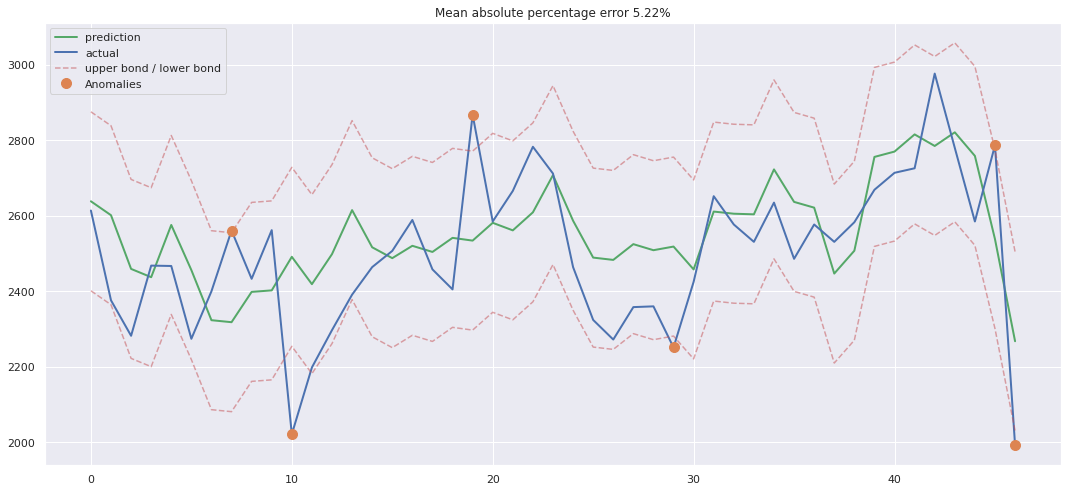

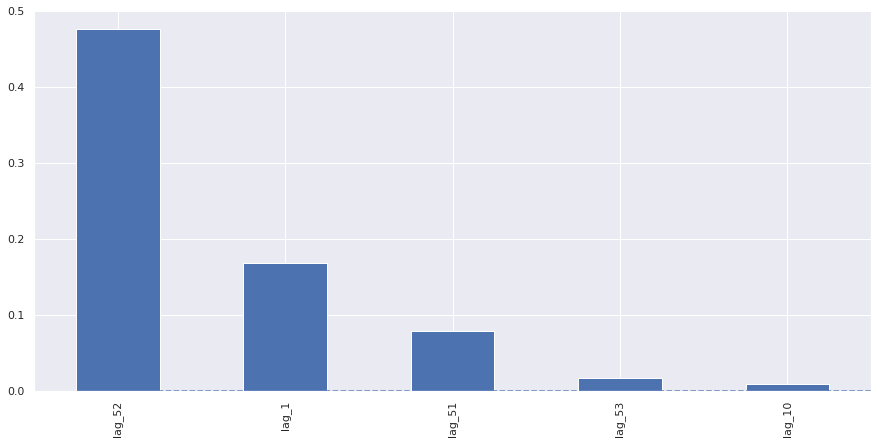

In [51]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso,normas = True)

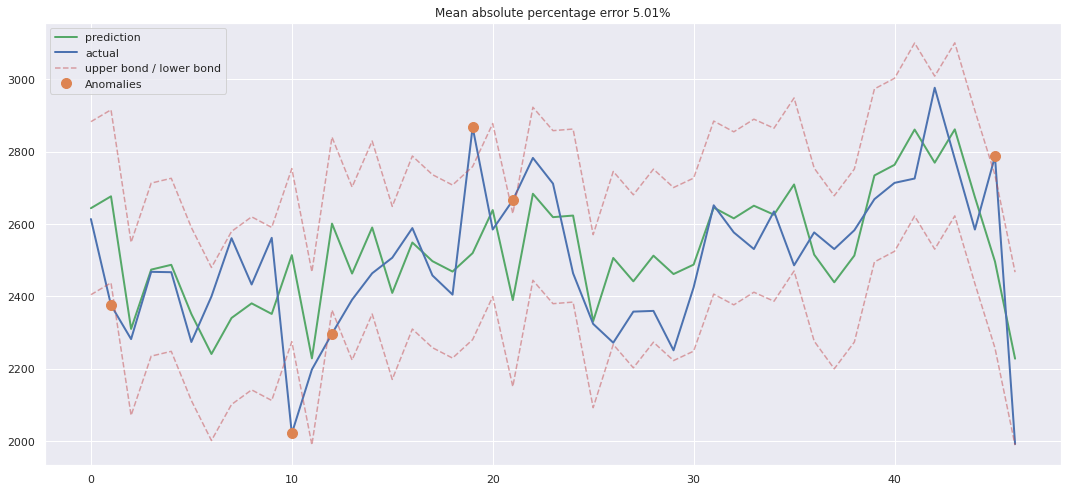

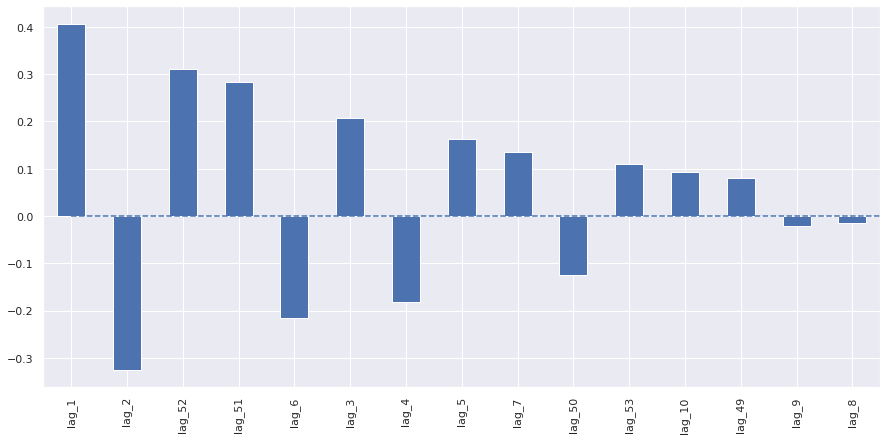

In [52]:
elasticnet = ElasticNetCV(cv=tscv, eps=0.00001,alphas=np.linspace(0, 100))
elasticnet.fit(X_train, y_train)

plotModelResults(elasticnet, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(elasticnet,normas = True)

Далее применим методы градиентного бустинга

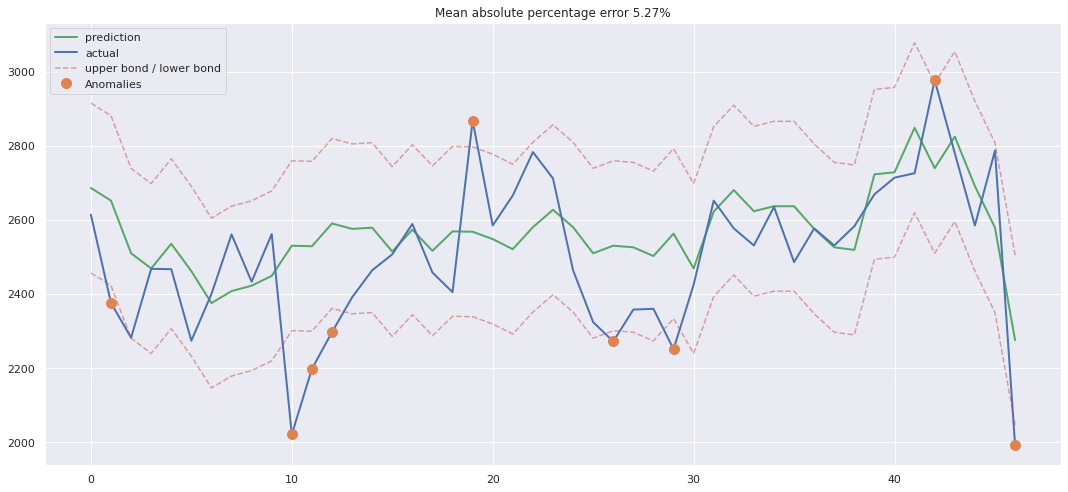

In [53]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

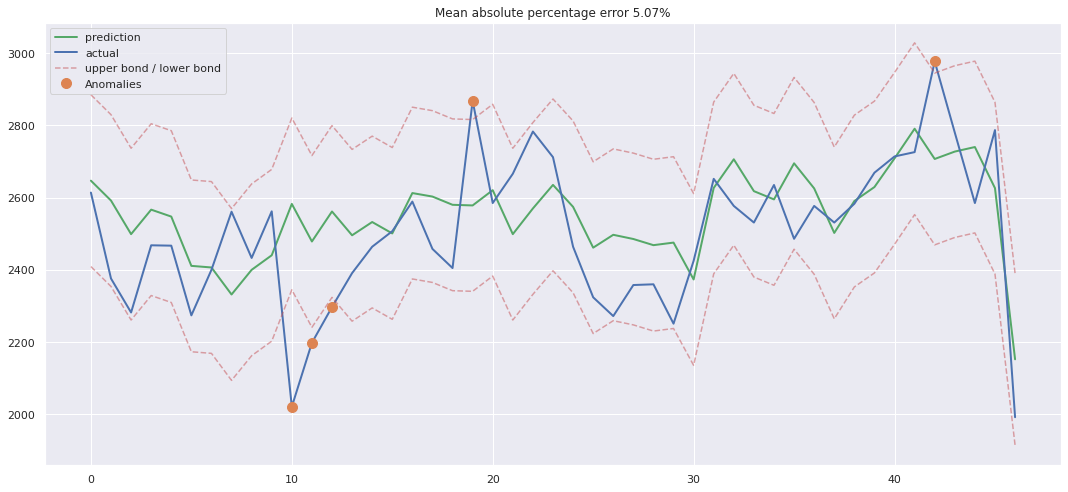

In [54]:
gbr2 = GradientBoostingRegressor(n_estimators=100)
gbr2.fit(X_train_scaled, y_train)

plotModelResults(gbr2, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

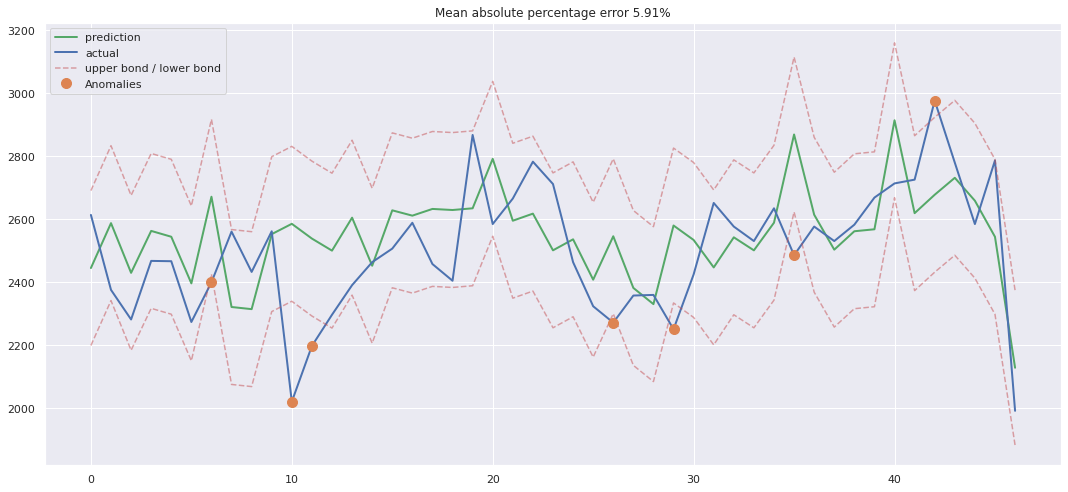

In [55]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='MAPE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Рассмотрим, как работает библиотека Prophet от Facebook

In [65]:
from fbprophet import Prophet

In [66]:
# number of future predictions
predictions = 70
# creating a specific format dataset 
data = pd.DataFrame([dates[7*i] for i in range(len(dates)//7)])
data['y'] = [sum(acc.values[7*i:7*(i+1)]) for i in range(len(acc.values)//7)]
data.columns = ['ds', 'y']
df = data
df.tail()

ds     y
203 2017-11-22  2977
204 2017-11-29  2780
205 2017-12-06  2585
206 2017-12-13  2787
207 2017-12-20  1992

In [67]:
# reserve some data for testing
train_df = df[:-predictions]
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='W')
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
203 2017-11-19
204 2017-11-26
205 2017-12-03
206 2017-12-10
207 2017-12-17

In [68]:
# finally, making predictions
forecast = model.predict(future)

Mean absolute percentage error 21.92%


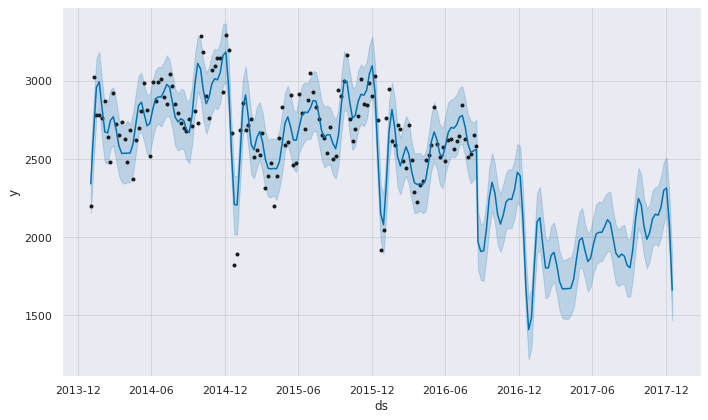

In [69]:
# pictures!
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

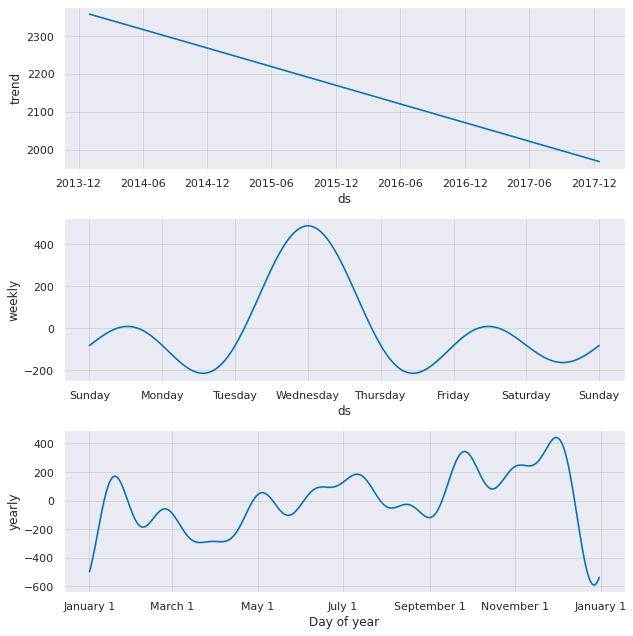

In [70]:
_ = model.plot_components(forecast)

In [71]:
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

INFO:numba.cuda.cudadrv.driver:init


In [72]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [75]:
data = pd.DataFrame([dates[7*i] for i in range(len(dates)//7)])
data['y'] = [sum(acc.values[7*i:7*(i+1)]) for i in range(len(acc.values)//7)]

In [76]:
# Adding the lag of the target variable from 100 steps back up to 400
data = pd.DataFrame(data.y.copy())
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# take a look at the new dataframe 
data.tail()

y   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7   lag_8  \
203  2977  2726.0  2714.0  2669.0  2583.0  2531.0  2577.0  2486.0  2635.0   
204  2780  2977.0  2726.0  2714.0  2669.0  2583.0  2531.0  2577.0  2486.0   
205  2585  2780.0  2977.0  2726.0  2714.0  2669.0  2583.0  2531.0  2577.0   
206  2787  2585.0  2780.0  2977.0  2726.0  2714.0  2669.0  2583.0  2531.0   
207  1992  2787.0  2585.0  2780.0  2977.0  2726.0  2714.0  2669.0  2583.0   

      lag_9  lag_10  lag_49  lag_50  lag_51  lag_52  lag_53  
203  2531.0  2577.0  2647.0  2938.0  2953.0  2960.0  3029.0  
204  2635.0  2531.0  2046.0  2647.0  2938.0  2953.0  2960.0  
205  2486.0  2635.0  1865.0  2046.0  2647.0  2938.0  2953.0  
206  2577.0  2486.0  2453.0  1865.0  2046.0  2647.0  2938.0  
207  2531.0  2577.0  2492.0  2453.0  1865.0  2046.0  2647.0

In [77]:
data = pd.concat([data,forecast],axis = 1).drop(['ds'],axis = 1)

In [80]:
y = data.dropna().y
data = data.dropna().drop(['y'], axis=1)

In [81]:
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

74

In [82]:
data_long = pd.DataFrame({0: data.values.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(5115, 2)


0  1
0  1893.0  0
1  1821.0  0
2  2668.0  0
3  3199.0  0
4  3295.0  0

In [83]:
X = extract_features(
    data_long, column_id=1, 
    impute_function=impute, 
    default_fc_parameters=settings_comprehensive,
    n_jobs=6
)
print(X.shape)

Feature Extraction: 100%|██████████| 26/26 [00:04<00:00,  5.71it/s]


(155, 787)


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

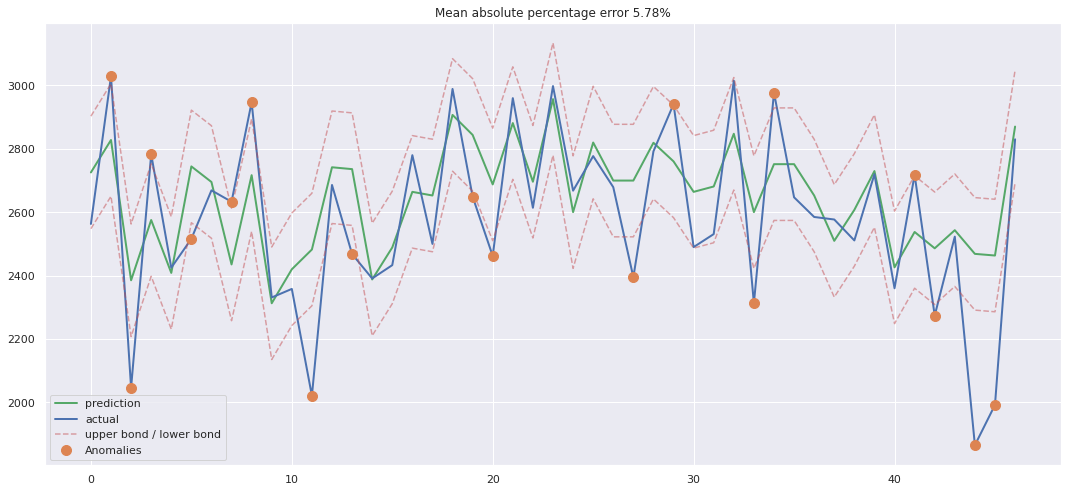

In [85]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

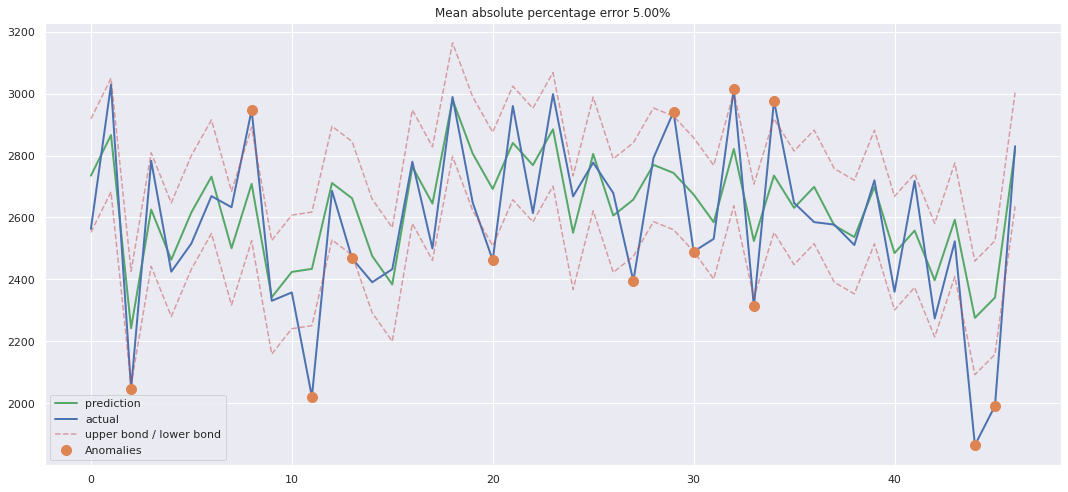

In [86]:
elasticnet.fit(X_train_scaled, y_train)

plotModelResults(elasticnet, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
#plotCoefficients(elasticnet,normas = True)

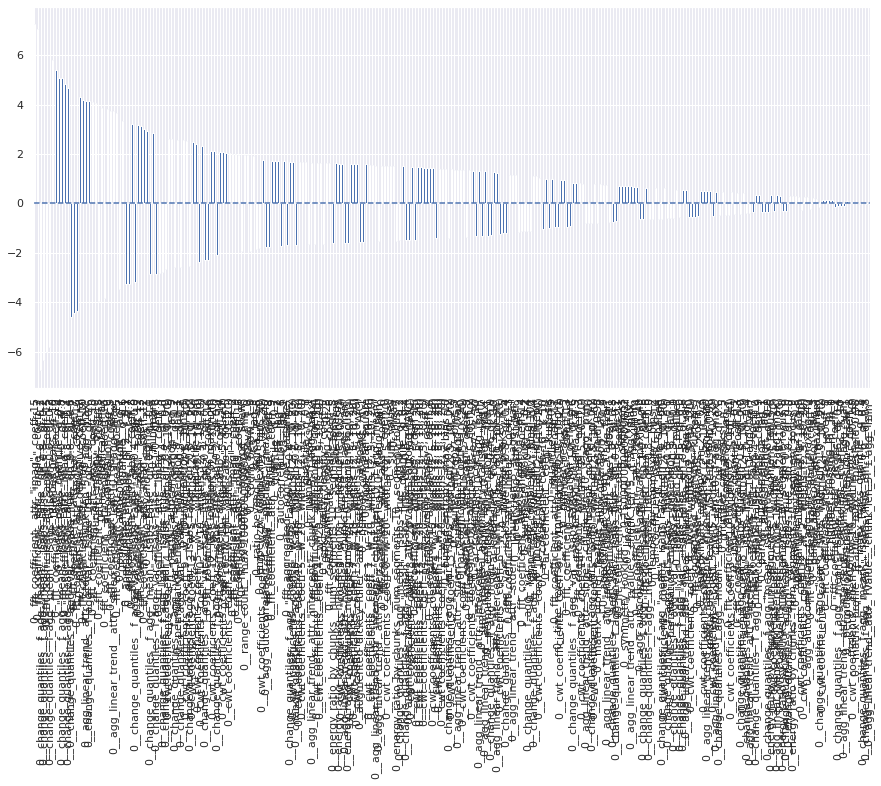

In [88]:
plotCoefficients(elasticnet,normas = True)